In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/erdemsmac/Desktop/Online Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df['StockCode']= df['StockCode'].astype(str)

In [6]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [7]:
random.shuffle(customers)

customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [8]:
purchases_train = []

for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:06<00:00, 570.73it/s]


In [9]:
purchases_val = []

for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 886.08it/s]


In [10]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3643041, 3679080)

In [11]:
model.init_sims(replace=True)

In [12]:
print(model)

Word2Vec(vocab=3175, size=100, alpha=0.03)


In [24]:
X = model[model.wv.vocab]

X.shape
print(X)

[[-0.08109272  0.15557668 -0.12440418 ...  0.0129682   0.16300763
  -0.06350408]
 [-0.03922372  0.17251249  0.05539373 ... -0.02152711 -0.12184724
  -0.17795235]
 [-0.16246223  0.07940982  0.20366298 ...  0.0360772  -0.15906619
  -0.17837732]
 ...
 [ 0.0280251   0.12133197 -0.09537512 ...  0.09423731 -0.03025082
  -0.01374071]
 [-0.04196066 -0.02169004 -0.01020842 ... -0.01450316  0.05278327
  -0.04890632]
 [-0.03614623 -0.00333255 -0.0140479  ... -0.03726865  0.04635158
  -0.06643227]]


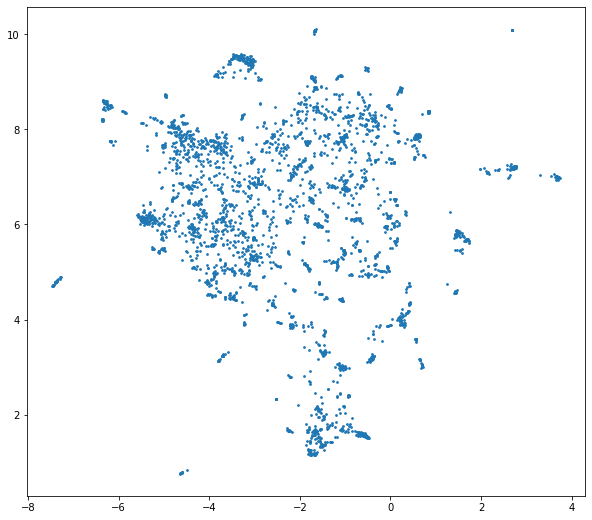

In [14]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [15]:
products = train_df[["StockCode", "Description"]]

products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [25]:
products_dict['22622']

['BOX OF VINTAGE ALPHABET BLOCKS']

In [17]:
def similar_products(v, n = 6):
    
    ms = model.similar_by_vector(v, topn= n+1)[1:]
      
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms 

In [18]:
similar_products(aggregate_vectors(model['90019A'])

[('PINK BOUDICCA LARGE BRACELET', 0.7872100472450256),
 ('BLUE MURANO TWIST BRACELET', 0.7539306879043579),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7517153024673462),
 ('JADE DROP EARRINGS W FILIGREE', 0.7512997388839722),
 ('GREEN HEART OF GLASS BRACELET', 0.7479144930839539),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7469421625137329)]

In [19]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [20]:
len(purchases_val[0])

359

In [21]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [22]:
similar_products(aggregate_vectors(purchases_val[0]))

[('LUNCH BAG PINK POLKADOT', 0.7303009033203125),
 ('JUMBO STORAGE BAG SUKI', 0.7276556491851807),
 ('TEATIME GEL PENS ASST', 0.7259013652801514),
 ('JUMBO BAG RED RETROSPOT', 0.7206532955169678),
 ('LUNCH BAG RED RETROSPOT', 0.7184800505638123),
 ('RED RETROSPOT PICNIC BAG', 0.716860830783844)]

In [23]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('JUMBO STORAGE BAG SKULLS', 0.7224259972572327),
 ('JUMBO BAG RED RETROSPOT', 0.7061381340026855),
 ('JUMBO STORAGE BAG SUKI', 0.6992077827453613),
 ('TOY TIDY PINK POLKADOT', 0.6984938383102417),
 ('JUMBO BAG PINK VINTAGE PAISLEY', 0.682038426399231),
 ('JUMBO BAG STRAWBERRY', 0.6775674223899841)]